# Project big data

Dit document bevat de opgave voor het project van het vak Big Data.
Tijdens dit project gaan we een dataset van Kaggle halen om tekst te classificeren.
Welke classificatie je wil uitvoeren is iets dat je zelf mag kiezen.
Een aantal voorbeelden zijn:
* Sentiment analyse
* Sarcasme detectie
* Hate speech detectie
* Fake news detectie
* ...

Belangrijk hierbij is dat de volgende twee kolommen in je dataset aanwezig zijn:
* Een kolom met een korte tekst
* Een kolom met een label/target dat je wil classificeren

Het doel is dan het getrainde model los te laten op een live-stream van reddit data en de classificatie uit te voeren.
De resultaten van de classificatie worden dan opgeslaan in een NoSQL database.

In grote lijnen zijn de te volgen stappen als volgt:
* Upload een gekozen dataset naar Hadoop
* Voer een analyse uit van de beschikbare gegevens door middel van Map Reduce
* Verwerk en train de dataset met behulp van Spark en MLlib
* Haal met een streaming service live data van reddit en laad het in met Spark (Spark Streaming, Kafka of Storm)
* Voer classificatie uit en sla de resultaten op in een NoSQL Database
* Haal een aantal resultaten op uit de NoSQL Database

## Praktisch

Bovenstaande opdracht voer je uit in **groepjes van max twee studenten**.

Voor deze opdracht moeten de volgende zaken ingediend worden:
* De code die je geschreven hebt voor de opdracht uit te voeren via deze github repo
* Een presentatie voor de mondelinge verdediging via deze github repo (het kan zijn dat dit door omstandigheden wegvalt)

De deadlines die aanwezig zijn voor het project zijn:
* Samenstellen van de groepen, keuze bespreking van het onderwerp/doel van de classificatie: Deadline **eind tweede week**
* Feedback over de reeds geschreven code van het project: **tijdens de les op 30 maart.**
* Code deadline: **05/06/2023 om 23u59**

## Stap 1: Beschrijving van het project

Geef hieronder de namen van je groep in:
* Team lid 1: Stroobants Quinten
* Team lid 2: Danau Lorenzo

Ga nu op zoek naar een dataset op Google of Kaggle om tekstverwerking te doen.
Op Kaggle vind je vooral engelstalige teksten maar via Google is het ook mogelijk om Nederlandstalige datasets te vinden.
[Dit](https://rdrr.io/github/weRbelgium/hatespeech.dutch/man/dutch_racistspeech.html) is een voorbeeld van een nederlandstalige dataset om racisme te detecteren in social media posts.
Deze dataset moet gebruikt worden voor een classificatie taak uit te voeren.
Dit houdt dus in dat er een kolom met tekst en een kolom met labels aanwezig moet zijn in de dataset.
Het doel van deze classificatie is vrij te kiezen.
Houd in rekening dat deze dataset gaat toegepast worden op social media data dus dat de tekst niet noodzakelijk heel lang moet zijn (het moeten dus geen hele boeken zijn).

**Beschrijf hieronder de gekozen dataset en wat je ermee probeert te bereiken. Geef ook de datastructuur weer en welke kolommen je wilt gebruiken. Indien je niet zeker bent of de dataset die je gekozen hebt goed werkt, mag je me het me steeds vragen.**

We gaan werken met een dataset die verschillende kolommen heeft maar we hebben er maar 2 nodig. De text en het label. Bij het label heb je 0, 1, en 2. 0 is hate speech, 1 is offensive language en 2 is neither. Bij de text heb je de ruwe data van een 20 duizend tal tweets. (Deze word eerst wel nog gekuist om een beter model te trainen).

In [1]:
import math
import opendatasets as od
import re
import pandas as pd
import pydoop.hdfs as hdfs
import statistics
import os  
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from pyspark.ml import PipelineModel
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import GBTClassificationModel

In [11]:
# Dataset downloaden
od.download('https://www.kaggle.com/mrmorj/hate-speech-and-offensive-language-dataset')

Skipping, found downloaded files in "./hate-speech-and-offensive-language-dataset" (use force=True to force download)


In [20]:
# Preprocessing van de text (verbeteren voor model te trainen)
def preprocess_tweet_text(tweet):
    # Remove URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    # Replace &amp; with "and"
    tweet = tweet.replace("&amp;", "and")
    
    # Remove mentions and hashtags
    tweet = re.sub(r"@[^\s]+", "", tweet)
    tweet = re.sub(r"#(\w+)", "", tweet)
    
    # Remove standalone "RT" mentions
    tweet = re.sub(r"(^|\s)RT(\s|$)", " ", tweet)
    
    # Remove non-ASCII characters
    tweet = tweet.encode("ascii", "ignore").decode()
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r"", tweet)
    
    # Remove other unwanted characters
    tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet)
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove extra whitespace
    tweet = re.sub(r"\s+", " ", tweet).strip()
    
    return tweet

In [13]:
# Csv in dataframe gieten en preprocessing applyen, exporten als cleaned.csv
df = pd.read_csv('./hate-speech-and-offensive-language-dataset/labeled_data.csv')
df['tweet'] = df['tweet'].apply(preprocess_tweet_text)

display(df)
df.to_csv('cleaned.csv', index=False)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,as a woman you shouldn t complain about cleani...
1,1,3,0,3,0,1,boy dats cold tyga dwn bad for cuffin dat hoe ...
2,2,3,0,3,0,1,dawg you ever fuck a bitch and she start to cr...
3,3,3,0,2,1,1,she look like a tranny
4,4,6,0,6,0,1,the shit you hear about me might be true or it...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you s a muthaf in lie right his tl is trash no...
24779,25292,3,0,1,2,2,you ve gone and broke the wrong heart baby and...
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [5]:
# make links with local and hdfs file systems
localFS = hdfs.hdfs(host='')
client = hdfs.hdfs(host='localhost', port=9000)

# if directory does not exists - make directory
if not client.exists('/Oefeningen/Project'):
    client.create_directory('/Oefeningen/Project')
client.set_working_directory('/Oefeningen/Project')
print(client.working_directory())

# do some cleaning in case anything else than input.txt is present
for f in client.list_directory("."):
    if not f["name"].endswith("cleaned.csv"):
        client.delete(f["name"], True) # True om aan te geven dat folders ook verwijderd moeten worden

2023-05-07 14:51:40,734 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


/Oefeningen/Project


## Stap 2: Analyze van de dataset

In deze fase van het project gaan we een stuk code schrijven om de gekozen dataset up te loaden naar de hadoop distributie van de Virtuele Machine gebruikt tijdens de les.

Voorzie voldoende commentaar en maak gebruik van functies om de verschillende stappen op te delen en de structuur duidelijk te maken.

Voer de volgende stappen uit in de code cell hieronder met de commentaar: "# hdfs_deel 1"
* Upload de dataset naar een aparte directory met naam **Project**
* Vraag de volgende algemene zaken op over dit bestand door middel van hdfs commando's of map reduce applicaties met pydoop
 * Bestandsgrootte
 * Aantal replica's
 * Aantal blocks
 * Het aantal kolommen aanwezig in de dataset
* Verhoog het aantal replica's met twee. Vraag na aanpassing deze waarden terug op om het te verifieren. Is deze aanpassing gelukt? Indien niet, waarom niet?

In [15]:
# hdfs deel 1
localFS.copy("cleaned.csv", client, "cleaned.csv") # upload file to hdfs

0

In [16]:
%%writefile stap_1_analytics.py

import pydoop.mapreduce.api as api
import pydoop.mapreduce.pipes as pipes

class MyMapper(api.Mapper):            
    # Dan aantal kolommen per rij mappen    
    def map(self, context):
        column_amount = len(context.value.split(","))
        context.emit("aantal_kolommen", column_amount)
    
class MyReducer(api.Reducer):
    # Alleen aantal_kolommen reducen met max()
    def reduce(self, context):
        if(context.key == 'aantal_kolommen'):
            context.emit(context.key, max(context.values))

FACTORY = pipes.Factory(MyMapper, reducer_class=MyReducer)        
        
def main():
    pipes.run_task(FACTORY)

if __name__ == '__main__':
    main()

Overwriting stap_1_analytics.py


In [ ]:
!hdfs dfs -rm -r /Oefeningen/Project/oef1
!pydoop submit --upload-file-to-cache stap_1_analytics.py stap_1_analytics /Oefeningen/Project/cleaned.csv /Oefeningen/Project/oef1 --entry-point main

In [17]:
# bestandsgrootte netter maken (thx chatgpt :P)
def sizeof_fmt(num, suffix='B'):
    for unit in ['', 'K', 'M', 'G', 'T', 'P', 'E', 'Z']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Y', suffix)

# file size, replica amount en block amount
path = "/Oefeningen/Project/cleaned.csv"
path_info = client.get_path_info(path)

size = (sizeof_fmt(path_info['size']))

print('Bestandsgrootte: {}'.format(size))
print('Aantal replicas: {}'.format(path_info['replication']))
aantal_blokken = math.ceil(path_info['size'] / path_info['block_size'])
print('Aantal blokken: {}'.format(aantal_blokken))

# replica nu verhogen met 2 (1+2=3)
client.set_replication(path, 3)

# checken of replicas verhoogd is effectief
print('--------------')
path_info = client.get_path_info(path) # path info opnieuw ophalen anders is de path_info nog niet bijgewerkt na de replications wel bij te werken
print('Aantal replicas na het te verhoogen: {}'.format(path_info['replication']))

Bestandsgrootte: 1.9 MB
Aantal replicas: 1
Aantal blokken: 1
--------------
Aantal replicas na het te verhoogen: 3


**Antwoord:**  
Bestandsgrootte: 1.9 MB  
Aantal replicas: 3  
Aantal blokken: 1
  
Aantal replicas na het te verhoogen: 3


Voorzie code om de output directory te verwijderen om niet steeds een andere naam te moeten kiezen in de cell met commentaar "# hdfs deel 2".

Schrijf in een **aparte file** met naam **stap_2_analytics.py** een  mapreduce applicatie die de volgende gegevens berekend van de dataset.
Eventueel mag deze file aangemaakt worden via een cell hieronder
* Het aantal rijen in de dataset
* Het aantal verschillende woorden, verwijder hiervoor alle karakters die geen letter zijn en maak geen onderscheid tussen upper en lowercase waarden
* Het aantal labels van elke klasse aanwezig in de dataset. Hoeveel klassen zijn er aanwezig en zijn ze reeds geencodeerd.
* De maximum, minimum en gemiddelde lengte van de tekst aanwezig in de dataset.
* Een histogram van het aantal woorden per rij. Zorg ervoor dat er minstens 5 bins aanwezig zijn maar indien je een dataset met lange tekst hebt mag dit meer zijn om een duidelijke histogram te krijgen.
* Emit ook de grenzen van de bins
* Bereken ook het aantal missing values die in je dataset aanwezig zijn.
* Voorzie ook een counter om de vooruitgang van de applicatie te tracken

In [20]:
%%writefile stap_2_analytics.py

#hdfs deel 2

import pydoop.mapreduce.api as api
import pydoop.mapreduce.pipes as pipes
import statistics

unieke_woorden_set = set()

class MyMapper(api.Mapper):
    def __init__(self, context):
        super(MyMapper, self).__init__(context)
        context.set_status("initializing mapper")
        self.input_words = context.get_counter("WORDCOUNT", "INPUT_WORDS")
        
    def map(self, context):

        # Aantal rijen
        context.emit("Aantal_rijen", 1)

        # Aantal verschillende woorden
        rijen = context.value.split(",")
        woorden = rijen[6].split(" ")
        for woord in woorden:
            context.emit("Woord", woord)
            print(woord)
        
        # Min/max/gem lengte van de tekst 
        context.emit("Lengte", len(woorden))
                
        # Histogram (min aantal woorden is 1 en max aantal woorden is 34, dus we gaan bins maken per stapjes van 5)             
        # De grenzen van de bins zitten in de key, bv bin_1_5 is de bin van 1 tot en met 5.
        if(len(woorden) <= 5):
            context.emit("bin_1_5", 1)
        if(len(woorden) > 5 and len(woorden) <= 10):
            context.emit("bin_6_10", 1)
        if(len(woorden) > 10 and len(woorden) <= 15):
            context.emit("bin_11_15", 1)          
        if(len(woorden) > 15 and len(woorden) <= 20):
            context.emit("bin_16_20", 1) 
        if(len(woorden) > 20 and len(woorden) <= 25):
            context.emit("bin_21_25", 1) 
        if(len(woorden) > 25 and len(woorden) <= 30):
            context.emit("bin_26_30", 1) 
        if(len(woorden) > 30 and len(woorden) <= 35):
            context.emit("bin_31_35", 1)    

        # Lege of whitespace velden tellen
        for item in rijen:
            if item is None or item == "":
                context.emit("Lege_velden", 1)
                
        context.increment_counter(self.input_words, len(woorden))
                
            
            
class MyReducer(api.Reducer):
    def __init__(self, context):
        super(MyReducer, self).__init__(context)
        context.set_status("initializing reducer")
        self.output_words = context.get_counter("WORDCOUNT", "OUTPUT_WORDS")
        
    global unieke_woorden_set
    def reduce(self, context):
         
        # Aantal rijen
        if(context.key == 'Aantal_rijen'):
            context.emit(context.key, sum(context.values))
            
        # Aantal verschillende woorden
        if(context.key == 'Woord'):
            unique_values = {}

            for value in context.values:
                unique_values[value] = True

            count = len(unique_values)
            context.emit("Aantal verschillende woorden", count)

       # Min/max/gem lengte van de text
        if(context.key == 'Lengte'):
            valuesfix = list(context.values)
            context.emit((context.key + '_min'), min(valuesfix))
            context.emit((context.key + '_max'), max(valuesfix))
            context.emit((context.key + '_gem'), statistics.mean(valuesfix))
            
        # Histogram
        if(context.key == "bin_1_5"):
            context.emit("bin_1_5", sum(context.values)) 
        if(context.key == "bin_6_10"):
            context.emit("bin_6_10", sum(context.values))      
        if(context.key == "bin_11_15"):
            context.emit("bin_11_15", sum(context.values))   
        if(context.key == "bin_16_20"):
            context.emit("bin_16_20", sum(context.values))             
        if(context.key == "bin_21_25"):
            context.emit("bin_21_25", sum(context.values))
        if(context.key == "bin_26_30"):
            context.emit("bin_26_30", sum(context.values))
        if(context.key == "bin_31_35"):
            context.emit("bin_31_35", sum(context.values))
            
        # Lege of whitespace velden tellen
        if(context.key == 'Lege_velden'):
            context.emit(context.key, sum(context.values))    
            
        context.increment_counter(self.output_words, 1)

FACTORY = pipes.Factory(MyMapper, reducer_class=MyReducer)        
        
def main():
    pipes.run_task(FACTORY)

if __name__ == '__main__':
    main()

Overwriting stap_2_analytics.py


In [21]:
# dit commando kan gebruikt worden om de applicatie uit te voeren (pas het pad aan indien de notebook server niet draait in de directory van het project)
!hdfs dfs -rm -r /Oefeningen/Project/oef2
!pydoop submit --upload-file-to-cache stap_2_analytics.py stap_2_analytics /Oefeningen/Project/cleaned.csv /Oefeningen/Project/oef2 --entry-point main

rm: `/Oefeningen/Project/oef2': No such file or directory
2023-05-03 19:33:19,051 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-05-03 19:33:21,211 INFO client.DefaultNoHARMFailoverProxyProvider: Connecting to ResourceManager at /0.0.0.0:8032
2023-05-03 19:33:21,625 INFO mapreduce.JobResourceUploader: Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/bigdata/.staging/job_1683135043100_0001
2023-05-03 19:33:21,782 WARN mapreduce.JobResourceUploader: No job jar file set.  User classes may not be found. See Job or Job#setJar(String).
2023-05-03 19:33:21,812 INFO input.FileInputFormat: Total input files to process : 1
2023-05-03 19:33:21,874 INFO mapreduce.JobSubmitter: number of splits:1
2023-05-03 19:33:22,052 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1683135043100_0001
2023-05-03 19:33:22,053 INFO mapreduce.JobSubmitter: Executing with tokens: []
2023-05-03 19:33:22,142 IN

Download via python code in onderstaande cell de output van de map-reduce taak in de cell met de commentaar "#hdfs deel 3".
Bewaar dit bestand met de naam "output_stap_2.txt".
Print de antwoorden op de vragen berekend via de mapreduce applicatie en plot ook de histogram. 
Sla deze figuur ook op als een png met de naam "histogram_stap_2.png".
Zorg ervoor dat deze bestanden mee ingediend worden door ze toe te voegen aan git.

In [22]:
# hdfs deel 3
if os.path.exists("part-r-00000"):
    os.remove("part-r-00000")
    
if os.path.exists("output_stap_2.txt"):
    os.remove("output_stap_2.txt")    
    
src_hdfs_path = "hdfs://localhost:9000/Oefeningen/Project/oef2/part-r-00000"
dest_path = "" # lege dest path geeft zorgt ervoor dat die in de map wordt geplaatst waar de ipynb zich bevind en dat is wat we nodig hebben
hdfs.get(src_hdfs_path, dest_path)
os.rename('part-r-00000','output_stap_2.txt')

with open('output_stap_2.txt', 'r') as file:
    print(file.read())

Aantal verschillende woorden	19065
Lengte_min	1
Lengte_max	34
Lengte_gem	13.02489509360878
bin_1_5	3627
bin_6_10	6857
bin_11_15	5663
bin_16_20	4274
bin_21_25	3122
bin_26_30	1156
bin_31_35	85
Lege_velden	20
Aantal_rijen	24784



,tweet,aantal_woorden
0,as a woman you shouldn t complain about cleani...,23
1,boy dats cold tyga dwn bad for cuffin dat hoe ...,14
2,dawg you ever fuck a bitch and she start to cr...,16
3,she look like a tranny,5
4,the shit you hear about me might be true or it...,22
...,...,...
24778,you s a muthaf in lie right his tl is trash no...,17
24779,you ve gone and broke the wrong heart baby and...,14
24780,young buck wanna eat dat nigguh like i aint fu...,13
24781,youu got wild bitches tellin you lies,7


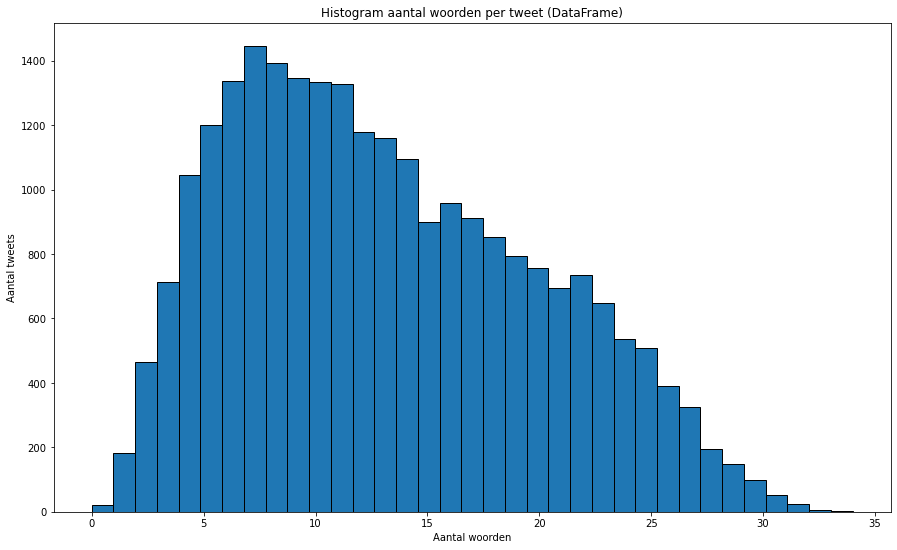

<Figure size 432x288 with 0 Axes>

In [23]:
df_plot = df.copy()
df_plot["aantal_woorden"] = [len(x.split()) for x in df["tweet"].tolist()]
display(df_plot[["tweet","aantal_woorden"]])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(9)

plt.hist(df_plot["aantal_woorden"], bins=35, edgecolor='black', linewidth=1)  # density=False would make counts
plt.ylabel('Aantal tweets')
plt.xlabel('Aantal woorden')

plt.title("Histogram aantal woorden per tweet (DataFrame)")

plt.savefig('histogram_stap_2_dataframe.png')

plt.show()
plt.draw()

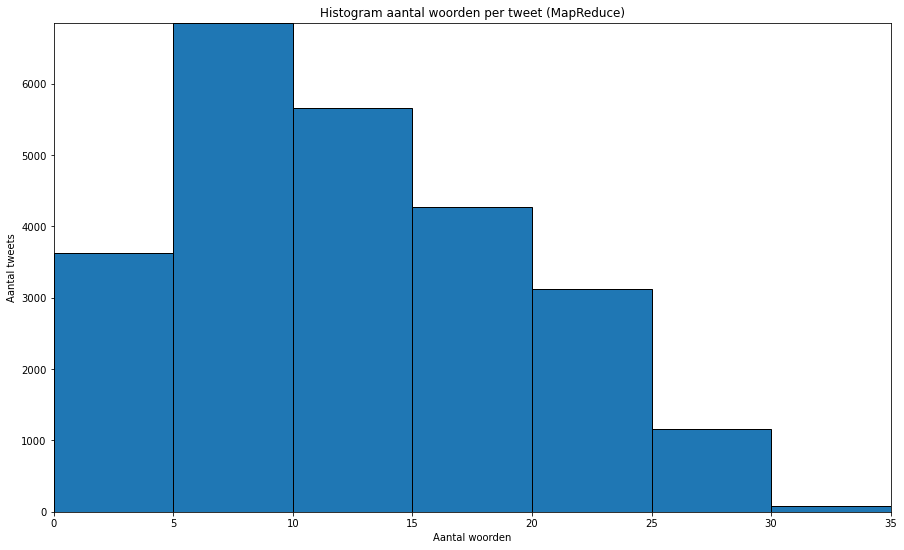

<Figure size 432x288 with 0 Axes>

In [24]:
bins = []
values = []

file1 = open('output_stap_2.txt', 'r')
count = 0

while True:
    count += 1
 
    line = file1.readline()
 
    if(line.startswith("bin")):
            lines_split = line.split()
            bin_n = lines_split[0]
            value_n = lines_split[1]
            
            bin_n_split = bin_n.split("_")
            bin_grenzen = [int(bin_n_split[1]), int(bin_n_split[2])]
            bins.append(bin_grenzen)
            
            values.append(int(value_n))

    if not line:
        break

file1.close()


fig,ax = plt.subplots()

fig.set_figwidth(15)
fig.set_figheight(9)

ax.set_xlim(left = 0, right = np.amax(bins))
ax.set_ylim(bottom = 0, top = np.amax(values))

for x in range(len(values)):   
    ax.add_patch(Rectangle((bins[x][0]-1, 0), 5, values[x], edgecolor='black', linewidth=1))
    
plt.xlabel("Aantal woorden")
plt.ylabel("Aantal tweets")

plt.title("Histogram aantal woorden per tweet (MapReduce)")

plt.savefig('histogram_stap_2_mapreduce.png')

plt.show()
plt.draw()

## Stap 3: Verwerken van de dataset en trainen ML-model

Nu we een beter inzicht hebben over de inhoud van de dataset is het mogelijk om via een (py)Spark Applicatie deze dataset te verwerken en een ML-model te trainen.
Schrijf alle code voor deze stap in een **aparte** python file met naam **stap_3_training.py**.
Zorg opnieuw voor voldoende commentaar en een duidelijke code structuur.

Maak hiervoor een Spark pipeline aan die de volgende stappen uitvoert.
* Omzetten tekst naar bag of words
* Zet de bag of words om naar een vector op basis van de TFIDF (Term Frequency Inverse Document Frequency Transformer).
* Maak een pipeline aan met een Gradient Boosted tree classification model. Doe gridsearch om de ideale hyperparameters te vinden en zorg ervoor dat er een outputkolom is met de voorspelde sentimenten (niet enkel de labels)
* Hou ook de benodigde trainingstijd bij!
* Bereken de accuraatheid en precision en recall op de testdata en maak een confusion-matrix
* Sla het ML-model op in de **Project** directory.
 
**Bespreek hieronder de code en de gemaakte keuzes. Beantwoord minstens onderstaande vragen**
* Uit welke stappen bestaat de pijplijn en wat voeren deze uit op je dataset.
* Welke hyperparameters geven het beste resultaat? Wat is de betekenis van deze hyperparameters? 
* Evalueer het model, gaat het de verschillende klasses even goed voorspellen/classificeren?

In [9]:
%%file stap_3_training.py
import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

start_time = time.time()

spark = SparkSession.builder.config("spark.driver.memory", "8g").config('spark.executor.memory', '4g').appName("Project").getOrCreate()

# df inlezen als sparkdf van csv
spark_df = spark.read.option("header",True).csv("/Oefeningen/Project/cleaned.csv")

# 20 null rijen droppen en van multiclass naar binary
spark_df = spark_df.filter(spark_df.tweet.isNotNull())
spark_df = spark_df.withColumn("class", col("class").cast(IntegerType()))
spark_df = spark_df.filter((col("class") == 1) | (col("class") == 2))
spark_df = spark_df.withColumn("class", when(col("class") == 2, 0).otherwise(col("class")))
# nu is 0 = neutral en 1 = offensive

# train test split
train_data, test_data = spark_df.select("tweet", "class").randomSplit([0.7, 0.3], seed=420)

# pipeline
tokenizer = RegexTokenizer(inputCol="tweet", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
cv = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")
gbt = GBTClassifier(labelCol="class", featuresCol="features")

# create pipeline
pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, gbt])

# create grid of hyperparameters for grid search
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [2, 4, 6]) \
    .addGrid(gbt.maxBins, [20, 30, 40]) \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.1, 0.01]) \
    .build()

# create evaluator
evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# create cross validator with 5-fold cross validation
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# fit the model
model = cv.fit(train_data)

end_time = time.time()
print("Total training time: {:.2f} seconds".format(end_time - start_time))
best_pipeline_model = model.bestModel
best_pipeline_model.save('/Oefeningen/Project/bestmodel')
spark.stop()

Overwriting stap_3_training.py


In [10]:
# execute stap 3
!python stap_3_training.py

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/07 14:54:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/07 14:55:00 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/05/07 14:55:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/07 14:55:38 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
Total training time: 16450.19 seconds                                           


In [11]:
spark2 = SparkSession.builder.config("spark.driver.memory", "8g").config('spark.executor.memory', '4g').appName("Project2").getOrCreate()

Accuracy = 0.9509679242616929
Weighted Precision = 0.9595008562312446
Weighted Precision = 0.9509679242616929


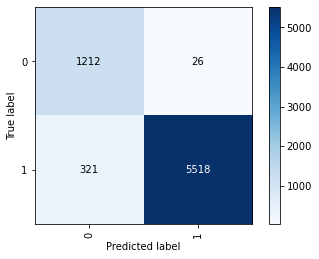

Parameters model:
maxDepth: 6
maxBins: 20
maxIter: 30
stepSize: 0.1


In [37]:
# omdat train test gesplitst is in een appart python file waar we nu niet meer
# aankunnen moeten we enkele stappen opnieuw doen:

loaded_pipeline_model = PipelineModel.load('/Oefeningen/Project/bestmodel')

spark_df = spark2.read.option("header",True).csv("/Oefeningen/Project/cleaned.csv")

# 20 null rijen droppen en van multiclass naar binary
spark_df = spark_df.filter(spark_df.tweet.isNotNull())
spark_df = spark_df.withColumn("class", col("class").cast(IntegerType()))
spark_df = spark_df.filter((col("class") == 1) | (col("class") == 2))
spark_df = spark_df.withColumn("class", when(col("class") == 2, 0).otherwise(col("class")))
# nu is 0 = neutral en 1 = offensive

# train test split
train_data, test_data = spark_df.select("tweet", "class").randomSplit([0.7, 0.3], seed=420)
# zelfde percentages en seed dus zal exact zoals in apart python file gesplitst worden

predictions = loaded_pipeline_model.transform(test_data)
predictions = predictions.withColumn("class", col("class").cast("double"))

predictions = predictions.withColumnRenamed("class", "label")

predictions_and_labels = predictions.select("prediction", "label").rdd
predictions_and_labels = predictions_and_labels.map(lambda x: (x.prediction, x.label))

metrics = MulticlassMetrics(predictions_and_labels)

accuracy = metrics.accuracy
print("Accuracy = %s" % accuracy)
weightedPrecision = metrics.weightedPrecision
print("Weighted Precision = %s" % weightedPrecision)
weightedRecall = metrics.weightedRecall
print("Weighted Precision = %s" % weightedRecall)

confusion_matrix = metrics.confusionMatrix().toArray()

classes = [str(i) for i in range(confusion_matrix.shape[0])]

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.xaxis.set_tick_params(rotation=90)

cbar = ax.figure.colorbar(im, ax=ax)

thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(j, i, format(confusion_matrix[i, j], '.0f'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black")

plt.show()

gbt_model = loaded_pipeline_model.stages[-1]

assert isinstance(gbt_model, GBTClassificationModel)

print("Parameters model:")
params = gbt_model.extractParamMap()
print("maxDepth:", params[gbt_model.maxDepth])
print("maxBins:", params[gbt_model.maxBins])
print("maxIter:", params[gbt_model.maxIter])
print("stepSize:", params[gbt_model.stepSize])

### Stappen pipeline:
- RegexTokenizer: tekstinput (tweet) wordt getokeniseerd in individuele woorden op basis van een reguliere expressie.
- StopWordsRemover: verwijdert veelvoorkomende stopwoorken uit de getokeniseerde woorden.
- CountVectorizer: converteert de getokeniseerde en gefilterde woorden naar een matrix van woordentellingen.
- IDF: Past de inverse document frequentie (IDF) transformatie toe op de woordentellingsmatrix. \
De laatste twee stappen kunnen aanschouwd worden als TF-IDF.
- GBTClassifier: dan het uiteindelijke machine learning gedeelte. Een gradient boosted tree classifier die zal trainen om de tweets te voorspellen op neutrale tekst of beledigend taalgebruik.

### Beste hyperparameters & uitleg:
- maxDepth: 6: dit bepaalt de maximale diepte van de decision tree. Het is het aantal lagen van de boom. Een hogere waarde kan leiden tot een meer complexe tree die beter past bij de trainingsgegevens, maar kan ook overfitting veroorzaken.
- maxBins: 20: dit bepaalt het maximum aantal bins dat wordt gebruikt om continue functies in te delen bij het opbouwen van de decision tree. Een hogere waarde kan leiden tot meer nauwkeurigheid, maar kan ook de prestaties van het algoritme verminderen.
- maxIter: 30: dit bepaalt het maximale aantal iteraties (boosting-rondes) dat wordt uitgevoerd om de prestaties van het model te verbeteren.
- stepSize: 0.1: dit bepaalt de grootte van de stap die wordt genomen bij het updaten van de gewichten van de bomen tijdens elke iteratie. Het is de leersnelheid. Een lagere waarde kan leiden tot langzamere, maar stabielere convergentie.

### Evaluatie:
- Het model lijkt ten eerste een zeer hoge score te behalen maar dit is natuurlijk een gevolg van de dataset die vrij ongebalanceerd is. Hier kunnen we niet veel aan doen omdat we dit vrij laat door hadden dus om nu nog met een andere dataset te gaan werken = onbegonnen werk. En de sataset gebalanceerd maken zorgt ervoor dat er meer als de helft van de data verloren gaat dus dat is ook niet ideaal voor de accuraatheid. Maar over het algemeen is het model meer als ok voor ons doel. In de voorspellingen is 0 = neutraal en 1 = offensive language, je zou het model dus kunnen gebruiken niet als strict classificerend maar eerder als waarschuwend van pas op, het kan zijn dat deze tekst offensive language bevat. Op die manier zal zij heel vaak juist zijn.

## Stap 4: Binnenhalen en verwerken live data met een streaming framework

In de les hebben we drie verschillende manieren gezien om data via Streams binnen te halen.
Bespreek hier kort de drie technieken (Spark Streaming, Kafka, Storm) en licht de punten toe waarop ze gelijkaardig zijn of verschillen. Geef ook aan welke keuze je maakt en waarom? (Mogelijke redenen zijn bijvoorbeeld de verschillen eerder besproken, je eigen gevoel bij de techniek of een goede tutorial die je gevonden hebt).

Bespreek de technieken hier en licht je keuze toe:

- Storm is een realtime verwerkingsplatform dat is ontworpen om grote hoeveelheden realtime gegevens te verwerken en te analyseren. Het ondersteunt meerdere programmeertalen, zoals Java en Python, en biedt een hoge doorvoer en lage latentie. Storm is ideaal voor toepassingen die gericht zijn op het uitvoeren van realtime analyses en het nemen van beslissingen op basis van die analyses.

- Spark Streaming maakt deel uit van het Spark-ecosysteem dat is ontworpen om realtime gegevens te verwerken door batchverwerking te simuleren met microbatches. Het ondersteunt integratie met verschillende gegevensbronnen zoals Kafka, Flume en Twitter, en heeft een hoge beschikbaarheid en fouttolerantie. Spark Streaming is met name geschikt voor toepassingen gericht op batchanalyse, machine learning en real-time datastreaminganalyse.

- Kafka is een gedistribueerd berichtensysteem dat in realtime gegevens verzamelt en opslaat uit verschillende bronnen, zoals sensoren, mobiele apparaten en websites. Het ondersteunt hoge schaalbaarheid, beschikbaarheid en betrouwbaarheid. Kafka kan worden geïntegreerd met verschillende verwerkingsframeworks zoals Spark en Storm.

Wij gaan gebruik maken van Kafka omdat die beschrijving het best past bij de doelstelling van het project en omdat we er al ervaring mee hebben door de streaming taak.

**Implementeren applicatie voor binnenhalen social media data en doorsturen naar pyspark streaming in de file stap_4_query_reddit.py**

Implementeer nu de code om data van Reddit binnen te halen.
Voer hiervoor de volgende stappen uit:
* Installeer de praw python package ([bron](https://praw.readthedocs.io/en/stable/getting_started/installation.html))
* Voer minstens de pre-requisites uit die je kan vinden in de [quick-start guide](https://praw.readthedocs.io/en/stable/getting_started/quick_start.html)
    * Indien er gevraagd wordt naar url/uri kan je linken naar http://www.google.be
    * Het client id staat naast onder de tekst "personal use script"
* Schrijf nu een reddit **read-only** python applicatie die comments uitleest, hierbij let je best op de volgende zaken:
    * Kies een relevante subreddit(s) die je uitleest (bvb over bepaalde nieuwsbronnen/politieke kanalen/favoriete serie of game/ .... Je kan ook kiezen om alle berichten te lezen door middel van het keyword "all".
    * Bekijk enkel comments die minstens 10 woorden bevatten (dus enkel alfabetische karakters).
    * Zorg ervoor dat alles lowercase is.
    * Let erop dat je comments bekijkt en geen submissions.
    * Bekijk ook de tutorial voor [een bot](https://praw.readthedocs.io/en/stable/tutorials/reply_bot.html) die alle submissions leest.
    * Het is de bedoeling dat deze applicatie niet stopt van zichzelf. (Manueel kan je het steeds stoppen met Ctrl + C)
* **Debugging stap (niet nodig in finale versie)**: Print de binnenkomende comments uit, zorg dat er minstens af en to een nieuwe comment binnenkomt. Anders kies je best wat extra subreddits om te monitoren.
* Schrijf elke comment in een aparte json-file en plaats deze in een folder op het hdfs. De filename mag het id zijn van het comment. In de json-files moet de volgende data zitten voor elke comment:
    * het ID
    * de tekst in de comment

**Let op: dit script moet in een terminal gestart worden om de notebook niet te blokkeren**


**Antwoord:**

In [ ]:
# install python praw package
!pip install praw

In [33]:
%%file stap_4_query_reddit.py
import praw
import re
import json
import pydoop.hdfs as hdfs

print("Deleting existing comments in folder")
files = hdfs.ls("/Oefeningen/Project/Comments/")
for file in files:
    hdfs.rmr(file)

# Preprocessing van de text (zelfde code als in begin van het project)
def preprocess_tweet_text(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = tweet.replace("&amp;", "and")
    tweet = re.sub(r"@[^\s]+", "", tweet)
    tweet = re.sub(r"#(\w+)", "", tweet)
    tweet = re.sub(r"(^|\s)RT(\s|$)", " ", tweet)
    tweet = tweet.encode("ascii", "ignore").decode()
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r"", tweet)
    tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

reddit = praw.Reddit(
    client_id="co084F0-3Ny8mDHZe0nSfw",
    client_secret="0_ri6wpokDxDoUXL_5IHv2gCaEDfug",
    user_agent="linuxvm:projectbigdataquintenlorenzo:v1.0.0",
    password="nCqarxBZ8n2eKLr",
    username="Illustrious-Ant9761",
)

reddit.read_only = True

# enkele subreddits genomen waar volgens:
# https://maxcandocia.com/article/2017/Jan/31/which-subreddits-swear-the-most/
# vaak in de comments gescholden wordt, als we andere gaan nemen kan het zijn dat we niet meteen
# veel offensive language comments vinden want er staan vast filters op wat je kan commenten op reddit

subreddit = reddit.subreddit("videos+The_Donald+tifu+news+Documentaries+AskReddit+worldnews+pics")

print("Writing comments to HDFS")
for comment in subreddit.stream.comments():
    cleanedcomment = preprocess_tweet_text(comment.body)
    if(len(cleanedcomment.split())>10):
        commentobj = {
          "id": comment.id,
          "tweet": cleanedcomment,
        }
        jsoncomment = json.dumps(commentobj, ensure_ascii=False)
        with hdfs.open(f"/Oefeningen/Project/Comments/{comment.id}.json", "w") as f:
            f.write(jsoncomment.encode("utf-8"))
            f.close()

Overwriting stap_4_query_reddit.py


**Implementeren applicatie voor verwerken tweets in de file stap_4_process_reddit.py**

Schrijf een spark streaming applicatie die de volgende stappen uitvoert:
* Maak een streaming spark applicatie aan dat de directory monitors waar de comments worden opgeslagen
* Laad het getrainde model in met de ML-pipeline als een broadcast variabele
* Zorg ervoor dat de frequentie waarin de data gechecked wordt 30 seconden is.
* Stuur de text van de ontvangen comment door de ML-pipeline en classificeer elke comment
* Print per verwerkte batch een dataframe met het aantal comments geclassificeerd per klasse.

In [20]:
%%file stap_4_process_reddit.py

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import *
from pyspark.sql.types import StringType

# Create a Spark session
spark = SparkSession.builder.appName("CommentClassification").getOrCreate()

# Load the trained model from the ML pipeline
model_path = '/Oefeningen/Project/bestmodel'
model = PipelineModel.load(model_path)

# Define the input directory where comments are stored
input_directory = '/Oefeningen/Project/Comments/'

# Set the streaming interval to 30 seconds
streaming_interval = "30 seconds"

# Define a schema for the JSON data
schema = StructType().add("id", StringType()).add("tweet", StringType())

# Create a streaming DataFrame by monitoring the input directory
comments_df = spark.readStream.schema(schema).json(input_directory)

# Apply the model to classify each comment
classified_df = model.transform(comments_df)

# Select the required columns
result_df = classified_df.select("id", "tweet", "prediction")

# Define a function to process each batch
def process_batch(batch_df, batch_id):
    # Count the number of predictions for class 0 and class 1
    class_0_count = batch_df.filter(batch_df.prediction == 0).count()
    class_1_count = batch_df.filter(batch_df.prediction == 1).count()
    
    # Create a DataFrame with class and count information
    count_df = spark.createDataFrame([(batch_id, class_0_count, class_1_count)], ["BatchID", "Class0Count", "Class1Count"])
    
    # Print the DataFrame
    count_df.show()

# Start the streaming query and process each batch
query = result_df.writeStream.outputMode("append").foreachBatch(process_batch).trigger(processingTime=streaming_interval).start()

# Wait for the streaming to finish
query.awaitTermination()

Overwriting stap_4_process_reddit.py


In [21]:
!python stap_4_process_reddit.py

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/21 21:00:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/21 21:00:57 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-57af019d-3843-4fdc-bc86-4d94d3b5b766. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/05/21 21:00:57 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/05/21 21:00:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/21 21:00:59 WARN InstanceBuilder$NativeBLAS: Failed to load implementation

## Stap 5: Opslaan in NoSQL database

In de les hebben we een aantal locally hosted NoSQL databases besproken. 
In dit project ga je gebruik maken van MongoDB. 

Geef een korte beschrijving van dit type database. Van welk type NoSQL database is MongoDB een implementatie? Wat zijn de belangrijkste termen die gebruikt worden in MongoDb om de datastructuur te definieren? Hoe wordt de data gestructureerd in MongoDB?

**Antwoord:**\
MongoDB is een documentgeoriënteerde database die behoort tot het type NoSQL-databases. In tegenstelling tot traditionele relationele databases, maakt MongoDB geen gebruik van tabellen en rijen, maar organiseert het gegevens in flexibele documenten die JSON-achtige structuren gebruiken.

MongoDB is specifiek een implementatie van een documentdatabase, wat betekent dat het is ontworpen om documenten op te slaan en te beheren. Documenten in MongoDB zijn opgebouwd uit velden en waarden, vergelijkbaar met de sleutel-waardeparen in JSON. Een verzameling van documenten wordt opgeslagen in een collectie.

De belangrijkste termen die worden gebruikt in MongoDB om de datastructuur te definiëren zijn:

Document: Een document is de basisgegevenseenheid in MongoDB. Het is een set van velden met bijbehorende waarden. Documenten worden opgeslagen in BSON (Binary JSON) formaat, dat een binair coderingsschema is voor representatie van JSON-achtige documenten.

Collectie: Een collectie is een groep van gerelateerde documenten in MongoDB. Het kan worden gezien als een equivalent van een tabel in een relationele database. Collecties bevatten documenten met verschillende structuren en schema's.

Veld: Een veld is een individuele eenheid binnen een document die een bepaalde waarde bevat. Elk veld heeft een naam en een waarde die kan bestaan uit verschillende datatypen, zoals strings, getallen, booleans, arrays, ingebedde documenten, enz.

Sleutel: Een sleutel is een speciaal veld in een document dat als unieke identificator fungeert voor dat document binnen een collectie. Het wordt vaak "_id" genoemd en kan handmatig worden toegewezen of automatisch gegenereerd worden door MongoDB.

Query: Een query is een instructie om documenten te vinden of op te halen uit een collectie op basis van bepaalde criteria. MongoDB ondersteunt een krachtige querytaal die het mogelijk maakt om te zoeken op velden, waarden, bereik, logische operatoren en meer.

Over het algemeen wordt de data in MongoDB gestructureerd in een flexibel, hiërarchisch formaat met behulp van documenten. Hierdoor kunnen ontwikkelaars complexe datastructuren maken zonder vooraf een strikt schema te definiëren, waardoor het eenvoudig is om wijzigingen in de datastructuur aan te brengen.






**Pas nu de applicaties aan uit stap 4.**

Pas de code uit **stap_4_query_reddit.py** aan en bewaar deze in een file met naam **stap_5_query_reddit.py**.
Zorg er hierbij voor dat zeker de volgende zaken ook worden opgeslagen in de json van elke comment:
* De naam van de auteur die het gepost heeft
* Het aantal replies op de comment
* De score van de comment
* Het aantal comments in de submission waartoe de comment hoort
* De score van de submission waartoe de comment behoort
* Een timestamp (bewaar dit als getal en zet het later voor naar mongodb geschreven wordt om naar een datetime)

Ook de code uit **stap_4_process_reddit.py** moet aangepast worden.
Na het classificeren van elke comment moeten we de resultaten nu opslaan in een mongoDB database.
Voeg de code toe aan het bestand **stap_5_process_reddit.py** om de nodige databases/collecties/... aan te maken.
Sla alle waarden in de json op in de MongoDB database en zorg er ook voor dat de zelf uitgevoerde classificatie toegevoegd wordt aan de database. Meer informatie kan je [hier](https://www.mongodb.com/docs/spark-connector/current/structured-streaming/#stream-to-mongodb-from-a-csv-file) vinden. Indien er problemen zijn met class-not-found errors mag je ook gebruik maken van de foreach methode in de datastreamwriter klasse van pyspark.

Bespreek hieronder hoe je de data gestructureerd hebt om het op te slaan. Welke waarden zijn je key(s)? Waarom heb je deze gekozen?

Bespreek de gebruikte datastructuur

In [69]:
%%file stap_5_query_reddit.py

import praw
import re
import json
import pydoop.hdfs as hdfs
from datetime import datetime

print("Deleting existing comments in folder")
files = hdfs.ls("/Oefeningen/Project/Comments/")
for file in files:
    hdfs.rmr(file)

# Preprocessing van de text (zelfde code als in begin van het project)
def preprocess_tweet_text(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = tweet.replace("&amp;", "and")
    tweet = re.sub(r"@[^\s]+", "", tweet)
    tweet = re.sub(r"#(\w+)", "", tweet)
    tweet = re.sub(r"(^|\s)RT(\s|$)", " ", tweet)
    tweet = tweet.encode("ascii", "ignore").decode()
    emoji_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" u"\U00002702-\U000027B0" u"\U000024C2-\U0001F251" "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub(r"", tweet)
    tweet = re.sub(r"[^a-zA-Z0-9]", " ", tweet)
    tweet = tweet.lower()
    tweet = re.sub(r"\s+", " ", tweet).strip()
    return tweet

reddit = praw.Reddit(
    client_id="co084F0-3Ny8mDHZe0nSfw",
    client_secret="0_ri6wpokDxDoUXL_5IHv2gCaEDfug",
    user_agent="linuxvm:projectbigdataquintenlorenzo:v1.0.0",
    password="nCqarxBZ8n2eKLr",
    username="Illustrious-Ant9761",
)

reddit.read_only = True

# enkele subreddits genomen waar volgens:
# https://maxcandocia.com/article/2017/Jan/31/which-subreddits-swear-the-most/
# vaak in de comments gescholden wordt, als we andere gaan nemen kan het zijn dat we niet meteen
# veel offensive language comments vinden want er staan vast filters op wat je kan commenten op reddit

subreddit = reddit.subreddit("videos+The_Donald+tifu+news+Documentaries+AskReddit+worldnews+pics")

print("Writing comments to HDFS")
for comment in subreddit.stream.comments():
    cleaned_comment = preprocess_tweet_text(comment.body)
    if len(cleaned_comment.split()) > 10:
        try:
            comment = reddit.comment(comment.id)
            comment.refresh()
            comment.replies.replace_more()
            replies = comment.replies.__len__()
            comment_obj = {
                "id": comment.id,
                "author": comment.author.name,
                "tweet": cleaned_comment,
                "replies": replies,
                "score": comment.score,
                "submission_comment_count": comment.submission.num_comments,
                "submission_score": comment.submission.score,
                "timestamp": comment.created_utc
            }
            json_comment = json.dumps(comment_obj, ensure_ascii=False)
            with hdfs.open(f"/Oefeningen/Project/Comments/{comment.id}.json", "w") as f:
                f.write(json_comment.encode("utf-8"))
                f.close()
        except Exception as e:
            print(f"[{datetime.now()}] An error occurred: {str(e)}, comment skipped")                

Overwriting stap_5_query_reddit.py


In [70]:
%%file stap_5_process_reddit.py

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql.functions import *
from pyspark.sql.types import *
import json
import os

# Create a Spark session
spark = SparkSession.builder.appName("CommentClassification").getOrCreate()

# Load the trained model from the ML pipeline
model_path = '/Oefeningen/Project/bestmodel'
model = PipelineModel.load(model_path)

# Define the input directory where comments are stored
input_directory = '/Oefeningen/Project/Comments/'

# Set the streaming interval to 30 seconds
streaming_interval = "30 seconds"

# Define a schema for the JSON data
schema = StructType().add("id", StringType()).add("author", StringType()).add("tweet", StringType()).add("replies", IntegerType()).add("score", IntegerType()).add("submission_comment_count", IntegerType()).add("submission_score", IntegerType()).add("timestamp", DoubleType ())

# Create a streaming DataFrame by monitoring the input directory
comments_df = spark.readStream.schema(schema).json(input_directory)

# Apply the model to classify each comment
classified_df = model.transform(comments_df)

# Select the required columns
result_df = classified_df.select("id", "author", "tweet", "replies", "score", "submission_comment_count", "submission_score", "timestamp", "prediction")

# Define the output directory for the JSON file
output_directory = './'

# Define the JSON file name
json_file_name = 'result.json'

# Define a function to write rows as JSON objects to a file
def write_json_file(rows):
    # Create an empty list to store JSON objects
    json_objects = []
    
    # Iterate over each row and convert it to a JSON object
    for row in rows:
        json_objects.append(row.asDict())
    
    # Define the file path for the JSON file
    json_file_path = os.path.join(output_directory, json_file_name)
    
    # Check if the JSON file exists
    if os.path.exists(json_file_path):
        # Read the existing contents of the file
        with open(json_file_path, 'r') as json_file:
            existing_json_objects = json_file.readlines()
        
        # Append the new JSON objects to the existing ones
        json_objects = existing_json_objects + [json.dumps(json_object) + '\n' for json_object in json_objects]
    
    # Write the JSON objects to the file
    with open(json_file_path, 'w') as json_file:
        for json_object in json_objects:
            json_file.write(json_object)

# Define a function to process each batch
def process_batch(batch_df, batch_id):
    # Count the number of predictions for class 0 and class 1
    class_0_count = batch_df.filter(batch_df.prediction == 0).count()
    class_1_count = batch_df.filter(batch_df.prediction == 1).count()
    
    # Create a DataFrame with class and count information
    count_df = spark.createDataFrame([(batch_id, class_0_count, class_1_count)], ["BatchID", "Class0Count", "Class1Count"])
    
    # Print the DataFrame
    count_df.show()
    
    # Input moest 'tweet' kolom hebben als text voor prediction maar nu renamen we die naar 'text'
    batch_df = batch_df.withColumnRenamed("tweet", "text")
    batch_df.show()
   
    # Write the rows as JSON objects to the file
    write_json_file(batch_df.collect())


# Start the streaming query and process each batch
query = result_df.writeStream.outputMode("append").foreachBatch(process_batch).trigger(processingTime=streaming_interval).start()

# Wait for the streaming to finish
query.awaitTermination()

Overwriting stap_5_process_reddit.py


Voor er verdergegaan wordt naar de laatste stap, gebruik een methode via de terminal om te verifieren of je data goed wordt opgeslaan. 
Print daarvoor bijvoorbeeld het aantal records aanwezig in de NoSQL-Database uit. 
Beschrijf hieronder de gevolgde werkwijze en maak een screenshot van de terminal met je uitgevoerde commando's.
Sla dit screenshot op onder de naam **stap_5_num_records.png**.

**Beschrijving werkwijze:**\
Omdat MongoDB niet werkte op de VM, hebben we eerst json objecten gemaakt van alle predictions en die opgeslaan in een bestand. Dit bestand word dan via desktop (windows) ingelezen en naar mongodb verstuurd.

In [2]:
import json
import pymongo
from datetime import datetime

Client = pymongo.MongoClient()
DataBase = Client.Project

Project = DataBase.Project
Project.drop()

Rijen = []
with open('result.json') as f:
    Rijen = f.readlines()
    for rij in Rijen:
        JSON_Rij_Ingelezen = json.loads(rij)
        timestamp = JSON_Rij_Ingelezen["timestamp"]
        JSON_Rij_Ingelezen["timestamp"] = datetime.fromtimestamp(timestamp)
        Project.insert_one(JSON_Rij_Ingelezen)

print(len(Rijen))

950


In [4]:
record_count = Project.count_documents({})
print("Number of records:", record_count)

Number of records: 950


## Stap 6: Lezen vanuit NoSQL database

Om het project af te ronden gaan we nu een aantal zaken uitlezen uit de NoSQL-database om de werking van de applicatie te monitoren. 
Maak hiervoor een aparte python file **stap_6_readNoSQL.py**.
Om voor voldoende records te zorgen, laat de scriptjes uit stap 5 lang genoeg lopen om minstens 200 resultaten te hebben.

Nu gaan er een aantal zaken opgevraagd moeten worden uit de database en geplot moeten worden.
Probeer hierbij zoveel mogelijk in het gekozen database systeem te werken en niet eerst alles uit te lezen in Spark.
Na het berekenen van de waarden kan je kiezen welke python tool je gebruikt voor de visualisaties uit te voeren.
Welke plot je gebruikt is vrij te kiezen maar zorg ervoor dat wat er getoond moet worden eenvoudig afgelezen kan worden (Let hierbij op grootte van de figuur, aantal elementen op de assen en een legende).
Sla ook elke figuur op in een **.png** bestand. Maak deze figuren leesbaar.

**Haal het totaal aantal comments op dat geclassificeerd werd in elke klasse (stap_6_fig_1.png).**
* Hier wil ik dus bvb. zien dat als je drie klasses hebt -> er zijn er 100 in klasse 1, 60 in klasse 2, 70 in klasse 3.

In [130]:
import matplotlib.pyplot as plt
import numpy as np

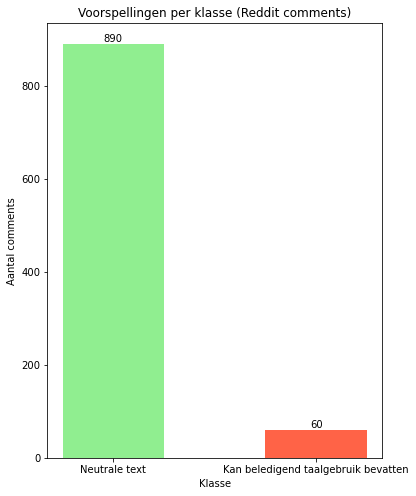

In [95]:
# Fetch the prediction data from the database
predictions = Project.find({}, {"prediction": 1})

# Process the data and count the occurrences of each prediction class
prediction_counts = {"0": 0, "1": 0}
for prediction in predictions:
    prediction_class = str(int(prediction["prediction"]))
    prediction_counts[prediction_class] += 1

# Prepare the data for plotting
prediction_classes = ["Neutrale text", "Kan beledigend taalgebruik bevatten"]
prediction_values = list(prediction_counts.values())

# Define colors for each class
colors = ['lightgreen','tomato']

# Set the figure size
plt.figure(figsize=(6, 8))

# Create the bar plot with adjusted bar width
bars = plt.bar(prediction_classes, prediction_values, width=0.5, color=colors)
plt.xlabel("Klasse")
plt.ylabel("Aantal comments")
plt.title("Voorspellingen per klasse (Reddit comments)")

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha="center", va="bottom")

plt.show()

**Toon een scatterplot met op de x-as het aantal comments van de submission, op de y-as de score van de submission en de classificatie als kleur (stap_6_fig_2.png). Horen positieve of negatieve comments vaker bij populaire submissions?**

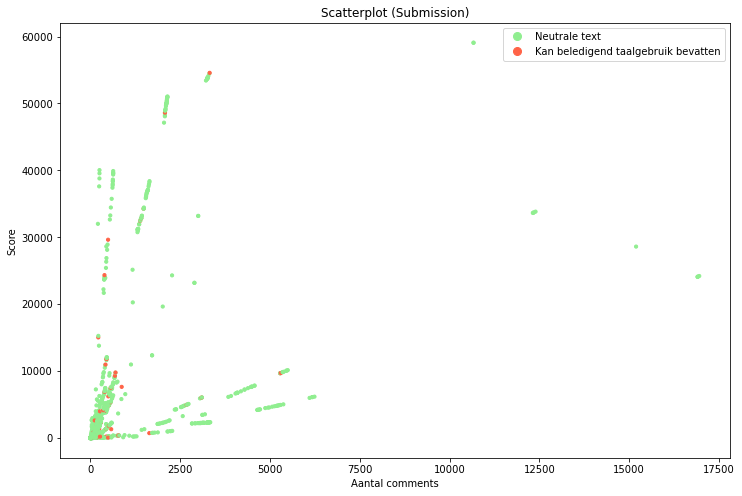

In [96]:
# Retrieve data from MongoDB
data = Project.find({}, {'submission_comment_count': 1, 'submission_score': 1, 'prediction': 1})

# Extract x and y data for plotting
x = []
y = []
colors = []

for item in data:
    x.append(item['submission_comment_count'])
    y.append(item['submission_score'])
    colors.append('lightgreen' if item['prediction'] == 0 else 'tomato')

# Set the size of the dots and the figure
dot_size = 10
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the scatterplot
ax.scatter(x, y, c=colors, s=dot_size)

# Set labels and title
ax.set_xlabel('Aantal comments')
ax.set_ylabel('Score')
ax.set_title('Scatterplot (Submission)')

# Add legend
green_dots = plt.Line2D([], [], marker='o', color='lightgreen', linestyle='None', markersize=8)
red_dots = plt.Line2D([], [], marker='o', color='tomato', linestyle='None', markersize=8)
ax.legend((green_dots, red_dots), ('Neutrale text', 'Kan beledigend taalgebruik bevatten'))

# Display the plot
plt.show()

Zoals je kan zien zijn er enkele outliers na 7500 aantal comments. Om de grafiek duidelijker te maken maken we de plot opnieuw zonder de outliers.

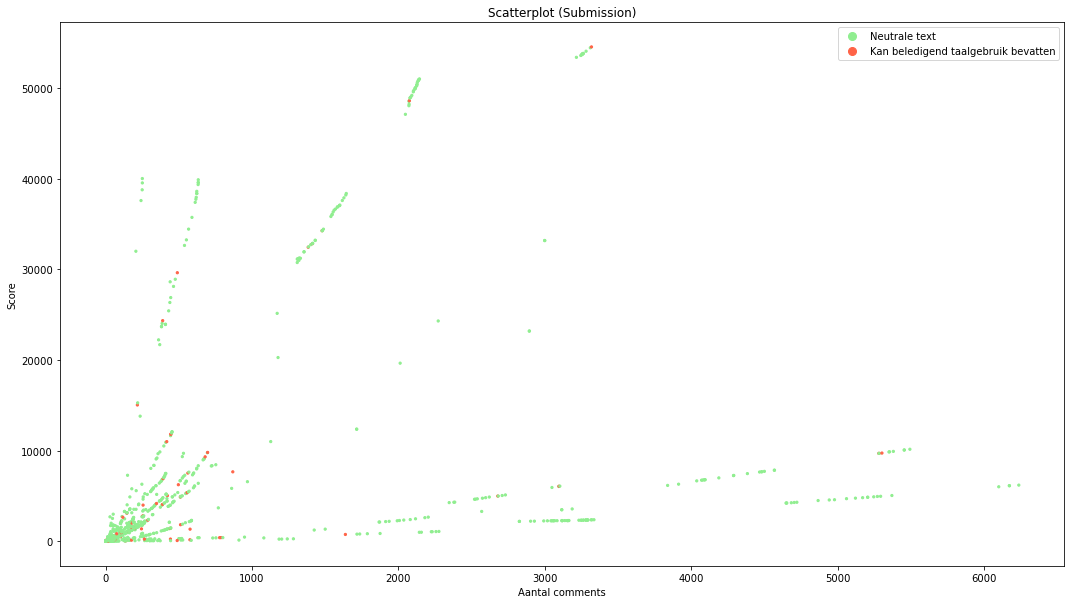

In [97]:
# Retrieve data from MongoDB
filter_condition = {'submission_comment_count': {'$lt': 7500}}
data = Project.find(filter_condition, {'submission_comment_count': 1, 'submission_score': 1, 'prediction': 1})

# Extract x and y data for plotting
x = []
y = []
colors = []

for item in data:
    x.append(item['submission_comment_count'])
    y.append(item['submission_score'])
    colors.append('lightgreen' if item['prediction'] == 0 else 'tomato')

# Set the size of the dots and the figure
dot_size = 5
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the scatterplot
ax.scatter(x, y, c=colors, s=dot_size)

# Set labels and title
ax.set_xlabel('Aantal comments')
ax.set_ylabel('Score')
ax.set_title('Scatterplot (Submission)')

# Add legend
green_dots = plt.Line2D([], [], marker='o', color='lightgreen', linestyle='None', markersize=8)
red_dots = plt.Line2D([], [], marker='o', color='tomato', linestyle='None', markersize=8)
ax.legend((green_dots, red_dots), ('Neutrale text', 'Kan beledigend taalgebruik bevatten'))

# Display the plot
plt.show()

Op deze grafiek lijkt het op het eerste gezicht dat er meer rode stipjes (negatieve comments) zijn bij minder bekende submissions (waar er minder comments zijn en de score lager is). Alleen kan je hier wel niet meteen van uit gaan of dit echt correct is, want er zijn in de dataset veel meer posts met minder comments en een lagere score (dus minder bekende submissions) dan heel drukke submissions. Hiermee moet je dus rekening houden. Als extraatje gaan we dus is eens op logaritmische schaal hetzelfde plot maken.

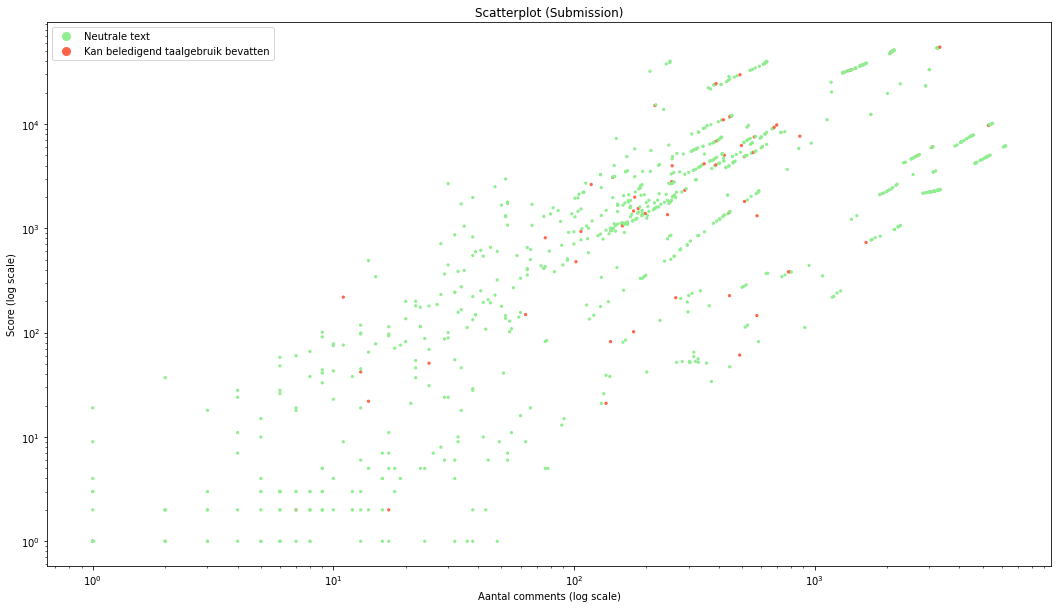

In [98]:
# Retrieve data from MongoDB
filter_condition = {'submission_comment_count': {'$lt': 7500}}
data = Project.find(filter_condition, {'submission_comment_count': 1, 'submission_score': 1, 'prediction': 1})

# Extract x and y data for plotting
x = []
y = []
colors = []

for item in data:
    x.append(item['submission_comment_count'])
    y.append(item['submission_score'])
    colors.append('lightgreen' if item['prediction'] == 0 else 'tomato')

# Set the size of the dots and the figure
dot_size = 5
fig, ax = plt.subplots(figsize=(18, 10))

# Plot the scatterplot with logarithmic x-axis and y-axis
ax.scatter(x, y, c=colors, s=dot_size)
ax.set_xscale('log')  # Set x-axis to logarithmic scale
ax.set_yscale('log')  # Set y-axis to logarithmic scale

# Set labels and title
ax.set_xlabel('Aantal comments (log scale)')
ax.set_ylabel('Score (log scale)')
ax.set_title('Scatterplot (Submission)')

# Add legend
green_dots = plt.Line2D([], [], marker='o', color='lightgreen', linestyle='None', markersize=8)
red_dots = plt.Line2D([], [], marker='o', color='tomato', linestyle='None', markersize=8)
ax.legend((green_dots, red_dots), ('Neutrale text', 'Kan beledigend taalgebruik bevatten'))

# Display the plot
plt.show()

Zo valt dus eigenlijk te concluderen dat er veel minder negatieve comments zijn maar dat de verdeling eigenlijk ongeveer gelijk loopt met de positieve comments (op vlak van horen negatieve comments vaker bij populaire submissions).

**Toon een histogram met het aantal comments per gebruiker. (stap_6_fig_3.png)**

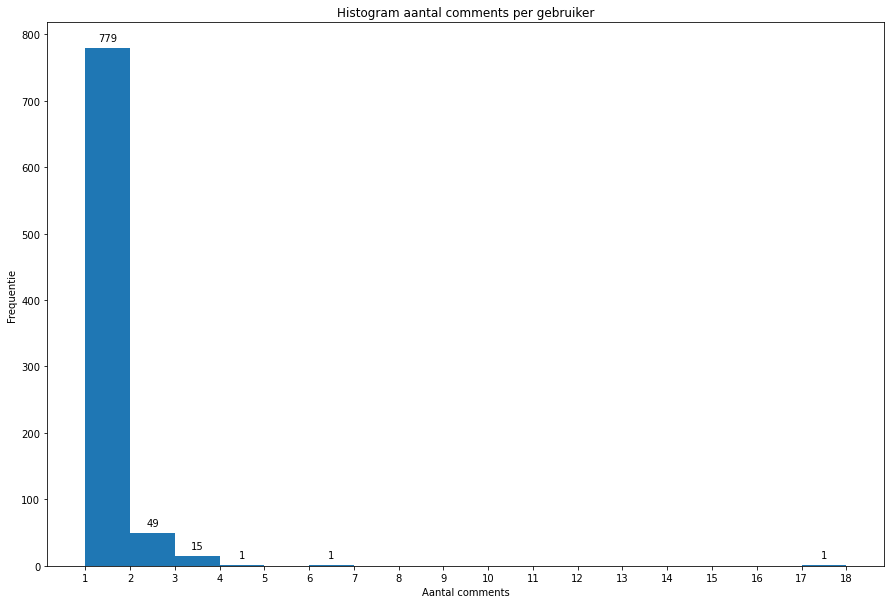

In [107]:
# Retrieve data from MongoDB
comments_per_user = Project.aggregate([
    {'$group': {'_id': '$author', 'count': {'$sum': 1}}}
])

# Extract comment counts
comment_counts = [doc['count'] for doc in comments_per_user]

# Increase figure size
plt.figure(figsize=(15, 10))

# Plot histogram
n, bins, patches = plt.hist(comment_counts, bins=17)
plt.xlabel('Aantal comments')
plt.ylabel('Frequentie')
plt.title('Histogram aantal comments per gebruiker')

# Adjust x-axis ticks
plt.xticks(range(int(min(comment_counts)), int(max(comment_counts)) + 1, 1))

# Add value labels
for i in range(len(patches)):
    height = patches[i].get_height()
    if height > 0:
        plt.annotate(str(int(height)), xy=(patches[i].get_x() + patches[i].get_width() / 2, height),
                     xytext=(0, 5), textcoords='offset points',
                     ha='center', va='bottom')

plt.show()

Conclusie: er zijn weer enkele outliers vanaf meer dan 4 comments per gebruiker. We kunnen met zekerheid spreken dat de comment-streaming applicatie/api dus bijna altijd comments geeft van een gebruiker, maar die gebruiker komt maar meestal maar een keer voor in de dataset. Dit is grote kans omdat de streaming zo werkt dat hij nieuwe comments ophaalt. De gebruiker in kwestie zou dan dus echt actief moeten commenten om meer dan 1 keer in de de dataset te voorkomen (in de pre defined subreddits  die de streamer volgt). Plus de streamer moet ook voldoen aan enkele eisen zoals minstens 10 woorden, als de gebruiker in kwestie dus iets korter comment komen die er ook niet bij. Dit zijn enkele redenen waarom de meeste comments van een gebruiker zijn die maar één keer voorkomt in de dataset.

**Zorg er nu voor dat je met de code van stap 5 comments hebt verzamelt van minstens 5 verschillende uren. Bereken nu met commando's naar het NoSQL-database systeem om het percentage comments geclassificeerd in elke klasse te berekenen per dag. Er gaan dus per uur x waarden geplot moeten worden met x je aantal klassen. Sla dit resultaat op in stap_6_fig_4.png**

**Is er een verband tussen het gemiddeld aantal comments van de verschillende klassen?**

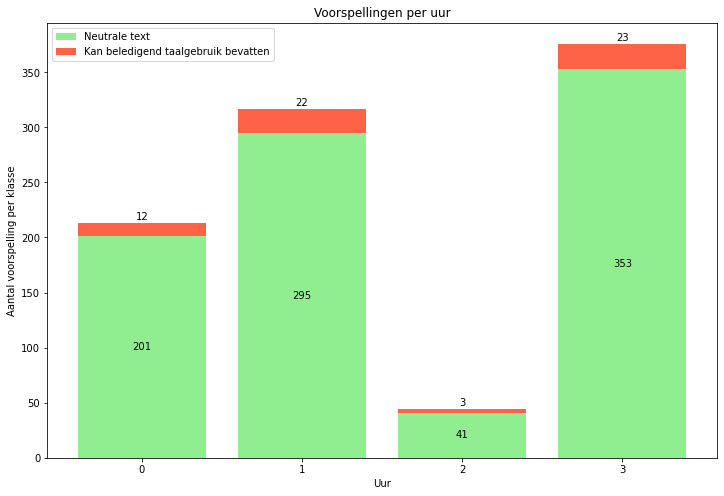

In [131]:
# Prepare the aggregation pipeline
pipeline = [
    {
        "$group": {
            "_id": {
                "hour": {"$hour": "$timestamp"},
                "prediction": "$prediction"
            },
            "count": {"$sum": 1}
        }
    },
    {
        "$project": {
            "_id": 0,
            "hour": "$_id.hour",
            "prediction": "$_id.prediction",
            "count": 1
        }
    },
    {
        "$sort": {"hour": 1}
    }
]

# Execute the aggregation query and store the results
results = Project.aggregate(pipeline)

# Initialize empty dictionaries to store the counts for each class
neutral_counts = {}
offensive_counts = {}

# Iterate over the results and populate the count dictionaries
for result in results:
    hour = result["hour"]
    prediction = result["prediction"]
    count = result["count"]

    if prediction == 0.0:
        neutral_counts[hour] = count
    elif prediction == 1.0:
        offensive_counts[hour] = count

# Create lists for x-axis (hours) and y-axis (counts) for each class
hours = sorted(set(neutral_counts.keys()) | set(offensive_counts.keys()))
neutral_values = [neutral_counts.get(hour, 0) for hour in hours]
offensive_values = [offensive_counts.get(hour, 0) for hour in hours]

# Create evenly spaced x-values for the bars
x_values = np.arange(len(hours))

# Set the figure size
plt.figure(figsize=(12, 8))

# Define the colors for each class
neutral_color = 'lightgreen'
offensive_color = 'tomato'

# Plot the bar chart with stacked bars and custom colors
neutral_bars = plt.bar(x_values, neutral_values, label='Neutrale text', color=neutral_color)
offensive_bars = plt.bar(x_values, offensive_values, bottom=neutral_values, label='Kan beledigend taalgebruik bevatten', color=offensive_color)

# Add labels inside the center of neutral class bars
for bar in neutral_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, height,
             ha='center', va='center', color='black')

# Add labels just above the offensive class bars
for i, (bar, count) in enumerate(zip(offensive_bars, offensive_values)):
    height_offensive = bar.get_height()
    height_neutral = neutral_bars[i].get_height()
    total_height = height_offensive + height_neutral
    plt.text(bar.get_x() + bar.get_width() / 2, total_height + max(offensive_values) / 20, count,
             ha='center', va='bottom', color='black')

# Set the x-ticks and labels
plt.xticks(x_values, hours)

# Set the labels and title
plt.xlabel('Uur')
plt.ylabel('Aantal voorspelling per klasse')
plt.title('Voorspellingen per uur')

# Add a legend
plt.legend()

# Display the plot
plt.show()

Voor de duidelijkheid: streaming query/proces heeft gerund van 00h01 tem 4h ergens, dus de uren labels kloppen wel, het is niet gewoon een optelling ;)